In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa import seasonal
from datetime import datetime as dt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

In [2]:
df = pd.read_csv("./parsed_data/combined_monthly_passenger_data.csv")

/var/folders/3_/t07qdblj0fd1phxb95ng5p780000gn/T/ipykernel_1823/1269732903.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./parsed_data/combined_monthly_passenger_data.csv")


In [3]:
df.columns

Index(['PASSENGERS', 'UNIQUE_CARRIER_NAME', 'ORIGIN', 'DEST', 'YEAR', 'MONTH',
       'CLASS'],
      dtype='object')

In [4]:
lax_df = df[df['ORIGIN'] == "LAX"]

In [5]:
lax_monthly_total_passengers = lax_df.groupby(['YEAR', 'MONTH']).agg(
    {
        'PASSENGERS': sum
    }
).reset_index()

/var/folders/3_/t07qdblj0fd1phxb95ng5p780000gn/T/ipykernel_1823/1007956679.py:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  lax_monthly_total_passengers = lax_df.groupby(['YEAR', 'MONTH']).agg(


In [6]:
for ix in lax_monthly_total_passengers.index:
    lax_monthly_total_passengers.at[ix, 'PERIOD'] = f"{lax_monthly_total_passengers.at[ix, 'YEAR']}-{lax_monthly_total_passengers.at[ix, 'MONTH']}"

<Axes: xlabel='PERIOD'>

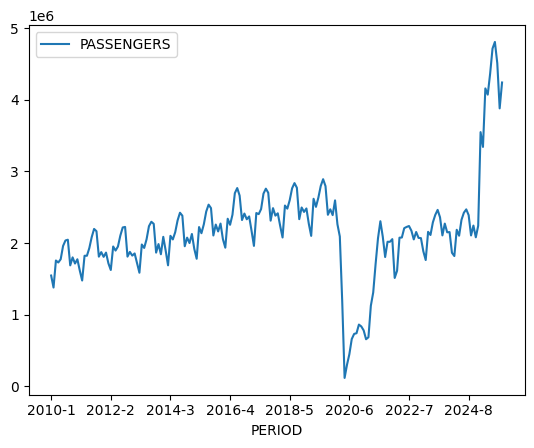

In [7]:
lax_monthly_total_passengers.plot(x='PERIOD', y='PASSENGERS')

We'll work with the pre-covid period as the pattern and trend are more consistent

In [8]:
lax_monthly_total_passengers['PARSED_PERIOD'] = lax_monthly_total_passengers['PERIOD'].apply(lambda x: dt.strptime(x, '%Y-%m'))

In [9]:
lax_passenger_per_period = lax_monthly_total_passengers[['PARSED_PERIOD', 'PASSENGERS']]
lax_passenger_per_period.index=lax_passenger_per_period['PARSED_PERIOD']
lax_passenger_per_period = lax_passenger_per_period.drop(['PARSED_PERIOD'], axis=1)


In [11]:
# define covid period
covid_start = '2019-06-01'
covid_end = '2021-06-01'

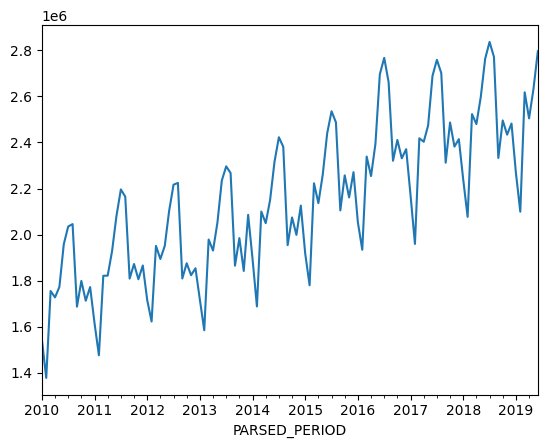

In [154]:
pre_covid_lax_slice = lax_passenger_per_period.loc[:covid_start]
# seasonal.seasonal_decompose(pre_covid_lax_slice).plot()
pre_covid_lax_slice['PASSENGERS'].plot()
plt.show()

In [192]:
# take the log for future stationarity purposes
pre_covid_lax_slice.loc[:, 'ln_PASSENGERS'] = np.log(pre_covid_lax_slice.loc[:, 'PASSENGERS'])

In [266]:
# create lags for training purposes
pre_covid_lax_slice.loc[:, 'L1_PASSENGERS'] = pre_covid_lax_slice.loc[:, 'PASSENGERS'].shift(1)
pre_covid_lax_slice.loc[:, 'L2_PASSENGERS'] = pre_covid_lax_slice.loc[:, 'PASSENGERS'].shift(2)

/var/folders/3_/t07qdblj0fd1phxb95ng5p780000gn/T/ipykernel_1823/2454502083.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_covid_lax_slice.loc[:, 'L2_PASSENGERS'] = pre_covid_lax_slice.loc[:, 'PASSENGERS'].shift(2)


In [267]:
# create training/test splits
train_start = '2018-01-01'
train_pre_covid = pre_covid_lax_slice.loc[: '2017-12-01']
test_pre_covid = pre_covid_lax_slice.loc[train_start:]

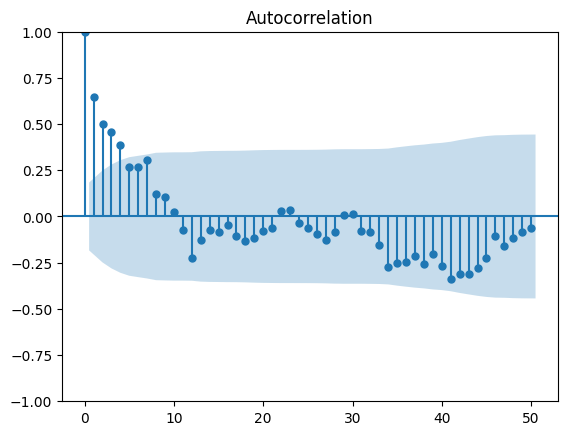

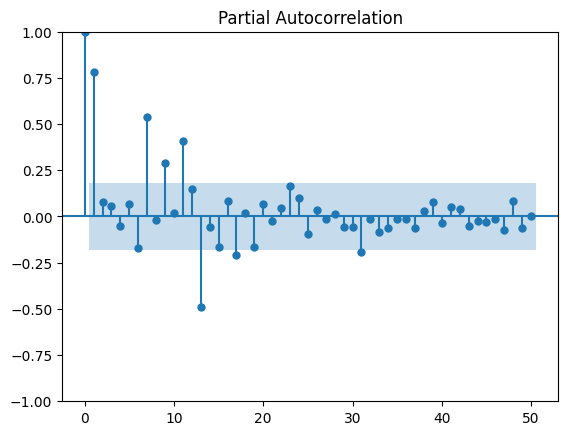

In [268]:
# test for stationarity
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(pre_covid_lax_slice['PASSENGERS'].diff(12), lags = 50, missing = 'drop')
plot_pacf(pre_covid_lax_slice['PASSENGERS'], lags = 50)
plt.show()

The pattern present in the ACF plot is typical of nonstationary and highly seasonal data. For the purposes of building intuition, we'll ignore the seasonal components and analyse the data as nonseasonal ARIMA at first then build our way up.

We will be following the progression showcased in: https://people.duke.edu/~rnau/411arim.htm

# Methodology
We are going to split the pre-covid data slice into a train/test split by training on all the data up until 2018-01-01. Then we will use the fitted model to project the values from 2018-01-01 to 2019-06-01. Once we have the fitted model, I will try to simulate forecasting by:
1. forecasting in sample: forecasting the training set starting from the first observation until the end of the training set
2. forecasting out sample: forecasting the test set starting from the last observation in training set

# First Order Auto Regressive Model (ARIMA(1,0,0))
First, we will explore fitting the data as a first order auto regressive model, ARIMA(1,0,0), with intercept

In [269]:
arima_model = SARIMAX(train_pre_covid['PASSENGERS'], trend = 'c')
res = arima_model.fit()
res.summary()

/Users/devint/dev_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/devint/dev_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             PASSENGERS   No. Observations:                   96
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -1302.033
Date:                Thu, 29 Jan 2026   AIC                           2610.065
Time:                        14:15:24   BIC                           2617.758
Sample:                    01-01-2010   HQIC                          2613.175
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4.633e+05   1.19e+05      3.909      0.000    2.31e+05    6.96e+05
ar.L1          0.7772      0.058     13.501      0.000       0.664       0.890
sigma2      3.406e+10      0.422   8.07e+10      0.000    3.41e+10    3.41e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.39   Jarque-Bera (JB):                 1.32
Prob(Q):                              0.53   Prob(JB):                         0.52
Heteroskedasticity (H):               1.37   Skew:                            -0.10
Prob(H) (two-sided):                  0.37   Kurtosis:                         2.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.86e+26. Standard errors may be unstable.
"""

/var/folders/3_/t07qdblj0fd1phxb95ng5p780000gn/T/ipykernel_1823/1226772705.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'L1_FIT'] = np.nan
/var/folders/3_/t07qdblj0fd1phxb95ng5p780000gn/T/ipykernel_1823/1226772705.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'L1_FIT'] = np.nan


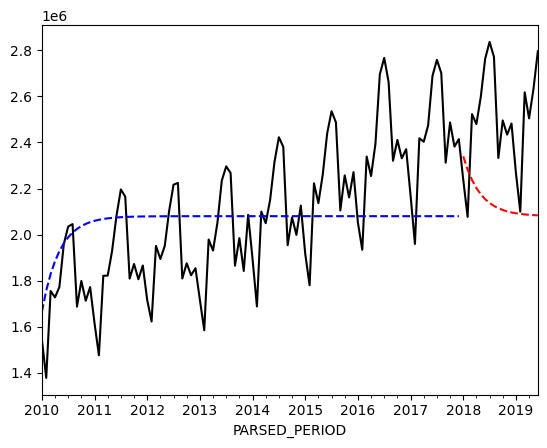

In [270]:
pre_covid_lax_slice['PASSENGERS'].plot(color='k')

# get the column index of passengers column so we can use it in iloc
PASSENGERS_ix = pre_covid_lax_slice.columns.get_loc('PASSENGERS')

def predict_arima100(arima, df, last_observation):
    ar_l1 = arima.params['ar.L1']
    intercept = arima.params['intercept']
    df.loc[:, 'L1_FIT'] = np.nan
    L1_fit_ix = df.columns.get_loc('L1_FIT')

    df.iloc[0, L1_fit_ix] = intercept + last_observation * ar_l1
    for ix in range(1, df.shape[0]):
        df.iloc[ix, L1_fit_ix] = intercept + df.iloc[ix-1, L1_fit_ix] * ar_l1

predict_arima100(res, test_pre_covid, train_pre_covid.iloc[-1, PASSENGERS_ix])
predict_arima100(res, train_pre_covid, train_pre_covid.iloc[0, PASSENGERS_ix])

train_pre_covid['L1_FIT'].plot(color='b', linestyle='--')
test_pre_covid['L1_FIT'].plot(color='r', linestyle='--')
#plt.axline(xy1=(0, train_pre_covid['PASSENGERS'].mean()), slope = 0, color='g')
#res.get_prediction(start=0, dynamic=1).predicted_mean.plot(color='k')
"""
get_prediction is ran to validate the predict function we wrote, by default, it uses the previous observation to perform one step
forward predictions in sample, however specifying dynamic=1 means it will start predicting on its predictions starting after the first
observation.
"""
    
plt.show()

As an ARIMA(1,0,0), we expect the fitted model to be a "mean-reverting". As we observe in the forecasted plots, in sample plot (blue), the values tend towards the mean, and the out of sample plot (red) tends towards the mean of the training sample). This is because in ARIMA(1,0,0), we find that the first order autoregressive coefficient must within the range (0,1). The intercept calculated is simply the mean of the training data, so the model moves fitted values closer and closer to the mean.

Let's see what the error plot looks like.

In [271]:
def calc_errors(truth, test, col):
    errors_df = test.loc[:, col] - truth.loc[train_start:, 'PASSENGERS']
    return errors_df

<Axes: xlabel='PARSED_PERIOD'>

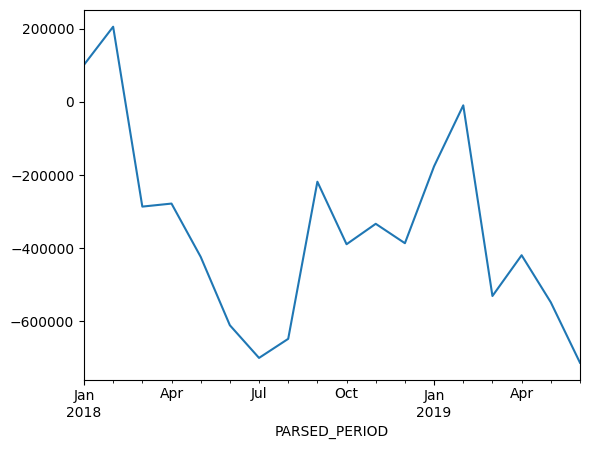

In [272]:
#AR100_errors = test_pre_covid.loc[:, 'L1_FIT'] - pre_covid_lax_slice.loc[train_start:, 'PASSENGERS']
AR100_errors = calc_errors(pre_covid_lax_slice, test_pre_covid, 'L1_FIT')

AR100_errors.plot()

As we expect, the fit should be pretty bad considering we observed heavy seasonality and trend in the original data

# Random Walk (ARIMA(0,1,0))
Next, we will look at modeling the data as a random walk, ARIMA(0,1,0).

In [344]:
sarima_model = SARIMAX(train_pre_covid['PASSENGERS'], order = (0,1,0), trend = 'c')
res = sarima_model.fit()
res.summary()

/Users/devint/dev_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/devint/dev_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             PASSENGERS   No. Observations:                   96
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1292.528
Date:                Thu, 29 Jan 2026   AIC                           2589.056
Time:                        14:55:20   BIC                           2594.164
Sample:                    01-01-2010   HQIC                          2591.120
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   9155.4000   2.01e+04      0.455      0.649   -3.03e+04    4.86e+04
sigma2      3.847e+10   5.53e+09      6.957      0.000    2.76e+10    4.93e+10
===================================================================================
Ljung-Box (L1) (Q):                   4.15   Jarque-Bera (JB):                 0.02
Prob(Q):                              0.04   Prob(JB):                         0.99
Heteroskedasticity (H):               1.21   Skew:                            -0.03
Prob(H) (two-sided):                  0.60   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [327]:
def fit_arima010(train, test, last_observation):
    mu = np.mean((train.loc[:, 'PASSENGERS'] - train.loc[:, 'L1_PASSENGERS']))
    #last_observation = train.iloc[-1, PASSENGERS_ix]
    test.loc[:, 'RANDOM_WALK_FIT'] = np.nan
    RANDOM_WALK_FIT_ix = test.columns.get_loc('RANDOM_WALK_FIT')
    test.iloc[0, RANDOM_WALK_FIT_ix] = last_observation + mu
    for ix in range(1, test.shape[0]):
        test.iloc[ix, RANDOM_WALK_FIT_ix] = test.iloc[ix-1, RANDOM_WALK_FIT_ix] + mu

fit_arima010(train_pre_covid, test_pre_covid, last_observation=train_pre_covid.iloc[-1, PASSENGERS_ix])
fit_arima010(train_pre_covid, train_pre_covid, last_observation=train_pre_covid.iloc[0, PASSENGERS_ix])

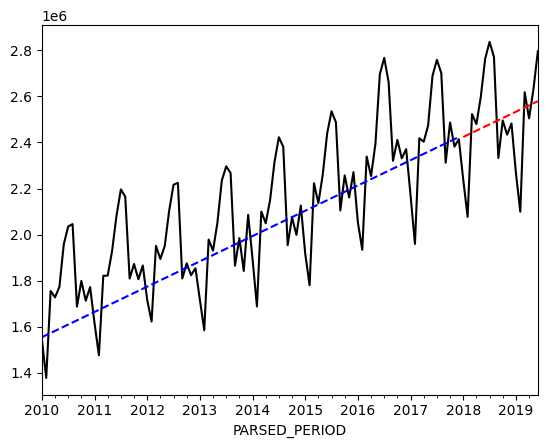

In [320]:
pre_covid_lax_slice['PASSENGERS'].plot(color='k')
test_pre_covid['RANDOM_WALK_FIT'].plot(color='r', linestyle='--')
train_pre_covid['RANDOM_WALK_FIT'].plot(color='b', linestyle='--')
plt.show()

The ARIMA(0,1,0) fit for the model looks to just be an extrapolation from the last observed data point. $\mu$ is defined as the average change between periods, in other words, it's simply slope of a line interpolated across the training data. So we would expect to see the ARIMA(0,1,0) to just be an extrapolation of this line.

On the term "random walk fit": My intuition is relating it back to the poisson distribution and the poisson random walk in which the steps taken are sampled from a poisson distribution. The poisson distribution only has one parameter: $\lambda$ defined as the expected average rate of occurences. In this case I imagine this is called a random walk fit where the expected number of steps from the previous observation is $\mu$.

In this case, SARIMAX provides an intercept term that is equal to $\mu$ calculated as the average change in $Y$ from one period to the next.

Let's take a look at what the errors look like.

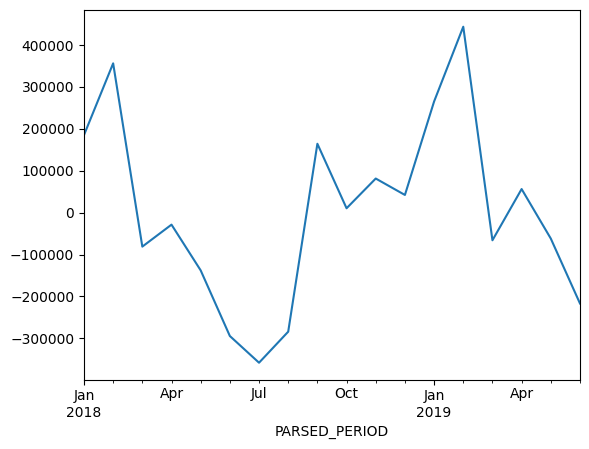

In [208]:
arima010_errors = calc_errors(truth=pre_covid_lax_slice, test=test_pre_covid, col="RANDOM_WALK_FIT")
arima010_errors.plot()
plt.show()

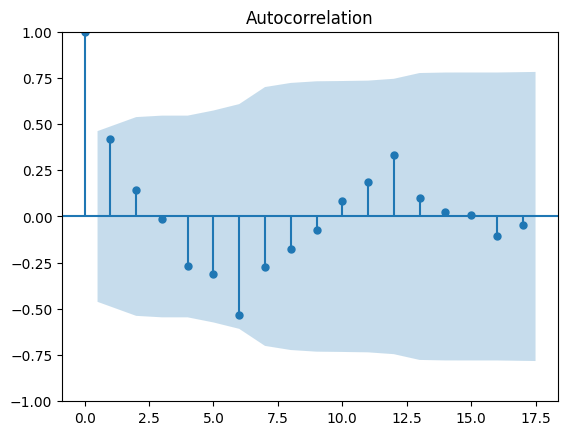

In [216]:
# checking arima(0,1,0 errors for auto correlation.
plot_acf(arima010_errors, lags=17)
plt.show()

# Differenced First Order Auto Regressive Model

Next we will fit an ARIMA(1,1,0). According to 411arim, if the errors of a random walk fit are autocorrelated, we might be able to alleviate that by adding one lag of the dependent variables into the model (adding the first order auto regressive term). In our case the errors of a random walk fit don't seem to be autocorrelated, therefore I expect the differenced first order auto regressive model to perform slightly worse.

In [346]:
sarima_model = SARIMAX(train_pre_covid['PASSENGERS'], order = (1,1,0), freq = 'MS', trend='c')
res = sarima_model.fit()
res.summary()

/Users/devint/dev_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             PASSENGERS   No. Observations:                   96
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -1290.198
Date:                Thu, 29 Jan 2026   AIC                           2586.395
Time:                        14:56:11   BIC                           2594.057
Sample:                    01-01-2010   HQIC                          2589.491
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.287e+04   2.12e+04      0.607      0.544   -2.87e+04    5.44e+04
ar.L1         -0.1708      0.147     -1.163      0.245      -0.458       0.117
sigma2       3.69e+10      0.021   1.73e+12      0.000    3.69e+10    3.69e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 1.06
Prob(Q):                              0.79   Prob(JB):                         0.59
Heteroskedasticity (H):               1.25   Skew:                            -0.25
Prob(H) (two-sided):                  0.54   Kurtosis:                         3.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.08e+28. Standard errors may be unstable.
"""

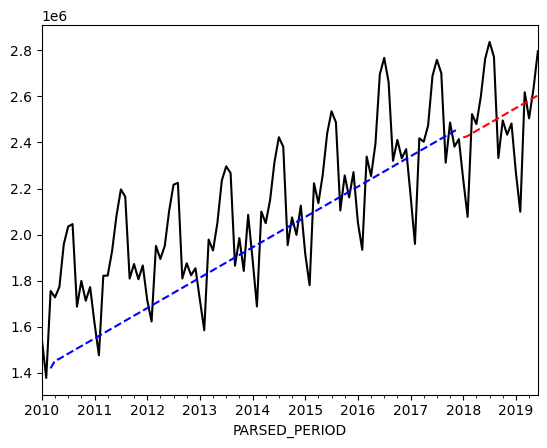

In [369]:
def predict_arima110(arima, train, raw_test):
    arl1 = arima.params['ar.L1']
    mu = arima.params['intercept'] #np.mean(train.loc[:, 'PASSENGERS'] - train.loc[:, 'L1_PASSENGERS'])
    """
    intuitively, I thought that mu should still just be the average change between each period in the training data, but this proves
    to be slightly off. In this case, we will simply take the intercept calculated by SARIMAX
    """
    
    # test.loc[:, 'FIRST_ORDER_DIFFS'] = test['L1_PASSENGERS'] - test['L2_PASSENGERS']
    test = raw_test.loc[raw_test['L2_PASSENGERS'].notna()]
    
    test.loc[:, 'FIRST_ORDER_DIFFS'] = np.nan
    test.loc[:, 'ARIMA110_FIT'] = np.nan

    first_order_diffs_ix = test.columns.get_loc('FIRST_ORDER_DIFFS')
    arima110_fit_ix = test.columns.get_loc('ARIMA110_FIT')
    l1_ix = test.columns.get_loc('L1_PASSENGERS')
    l2_ix = test.columns.get_loc('L2_PASSENGERS')

    test.iloc[0, first_order_diffs_ix] = test.iloc[0, l1_ix] - test.iloc[0, l2_ix]
    test.iloc[0, arima110_fit_ix] = test.iloc[0, first_order_diffs_ix] * arl1 + test.iloc[0, l1_ix] + mu
    test.iloc[1, first_order_diffs_ix] = test.iloc[0, arima110_fit_ix] - test.iloc[0, l2_ix]
    test.iloc[1, arima110_fit_ix] = test.iloc[1, first_order_diffs_ix] * arl1 + test.iloc[0, arima110_fit_ix] + mu

    for ix in range(2, test.shape[0]):
        test.iloc[ix, first_order_diffs_ix] = test.iloc[ix - 1, arima110_fit_ix] - test.iloc[ix - 2, arima110_fit_ix]
        test.iloc[ix, arima110_fit_ix] = test.iloc[ix, first_order_diffs_ix] * arl1 + test.iloc[ix-1, arima110_fit_ix] + mu

    return test['ARIMA110_FIT']
    

predict_out_sample = predict_arima110(res, train_pre_covid, test_pre_covid)
predict_in_sample = predict_arima110(res, train_pre_covid, train_pre_covid)

pre_covid_lax_slice['PASSENGERS'].plot(color='k')
predict_out_sample.plot(color='r', linestyle='--')
predict_in_sample.plot(color='b', linestyle='--')
#res.get_prediction(start=0, dynamic=2).predicted_mean.plot(color='k')
plt.show()

ARIMA(1,1,0) is intuitively ARIMA(1,0,0) but applied to differences instead of a lagged term. This is done because setting d=1 in ARIMA differences the lagged terms to try to achieve stationarity. Recall that we are attempting to use this model because error terms in the random walk were autocorrelated. We tried to account for the autocorrelation by adding back in autoregressive terms, hence p=1 in this model. I originally attempted to keep $\mu$'s calculation the same as in an ARIMA(0,1,0) ie $\mu$ is the average change in $Y$ from one period to the next in the training data. However, the intercept provided by SARIMAX is slightly different from that figure. 

TODO:
* I will need to further investigate the interpretation of the intercept in ARIMA(1,1,0).
* I also want to go back and add confidence intervals to the forecasts

# Simple Exponential Smoothing

ARIMA(0,1,1) without constant..

In [374]:
sarima_model = SARIMAX(train_pre_covid['PASSENGERS'], order = (0,1,1), freq = 'MS')
res = sarima_model.fit()
res.summary()

/Users/devint/dev_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             PASSENGERS   No. Observations:                   96
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1290.626
Date:                Thu, 29 Jan 2026   AIC                           2585.252
Time:                        15:53:22   BIC                           2590.360
Sample:                    01-01-2010   HQIC                          2587.316
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1537      0.121     -1.266      0.206      -0.392       0.084
sigma2      3.668e+10   8.69e-13   4.22e+22      0.000    3.67e+10    3.67e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                 0.77
Prob(Q):                              0.65   Prob(JB):                         0.68
Heteroskedasticity (H):               1.21   Skew:                            -0.22
Prob(H) (two-sided):                  0.60   Kurtosis:                         3.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.32e+38. Standard errors may be unstable.
"""

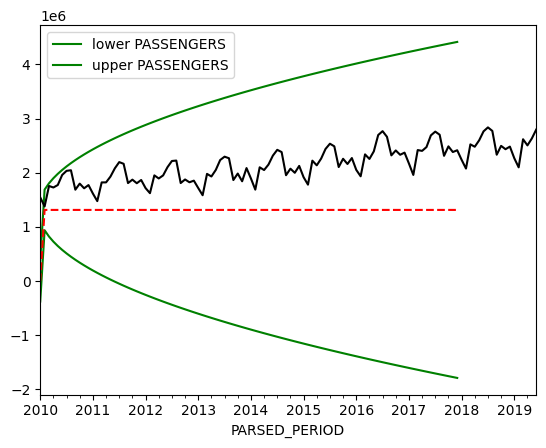

In [390]:
res.get_prediction(start=0, dynamic=1).conf_int().plot(color='g')
res.get_prediction(start=0, dynamic=1).predicted_mean.plot(color='r', linestyle='--')
pre_covid_lax_slice['PASSENGERS'].plot(color='k')
plt.show()